# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import os
from IPython.display import display
from sklearn.svm import SVC
import warnings
warnings.simplefilter(action='ignore')
plt.style.use('seaborn')

# Constants

In [ ]:
TEST_SIZE = 0.3
RANDOM_STATE = 42
FIGSIZE = (16,6)
CITIES = ['Ahmedabad','Bangalore','Chennai','Delhi','Hyderabad','Kolkata','Mumbai','Pune']
NUMERICAL_NROWS = 2
NUMERICAL_NCOLS = 2
PIE_FIGSIZE = (20,15)
MULTICOL_FIGSIZE=(16,8)
EVALUATION_NROWS = 1
EVALUATION_NCOLS = 2
CITY_NROWS = 4
CITY_NCOLS = 2
MODEL_EVALUATE_FIGSIZE=(16,16)
HYPERPARAMETER_TUNING_FIGSIZE = (20,20)

In [ ]:
all_data = pd.read_csv('_All_Cities_Cleaned.csv')

In [ ]:
df_dict = dict(zip(CITIES, [all_data[all_data['city'] == city].copy() for city in CITIES]))

In [ ]:
for city, df in df_dict.items():
    print(f"{city} -> {df_dict[city].isnull().sum()[df_dict[city].isnull().sum()>0]}")

Ahmedabad -> Series([], dtype: int64)
Bangalore -> Series([], dtype: int64)
Chennai -> Series([], dtype: int64)
Delhi -> Series([], dtype: int64)
Hyderabad -> Series([], dtype: int64)
Kolkata -> Series([], dtype: int64)
Mumbai -> Series([], dtype: int64)
Pune -> Series([], dtype: int64)


# Preprocessing

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
all_data['seller_type']= label_encoder.fit_transform(all_data['seller_type'])
all_data['layout_type']= label_encoder.fit_transform(all_data['layout_type'])
all_data['property_type']= label_encoder.fit_transform(all_data['property_type'])
all_data['locality']= label_encoder.fit_transform(all_data['locality'])
all_data['furnish_type']= label_encoder.fit_transform(all_data['furnish_type'])
all_data['city']= label_encoder.fit_transform(all_data['city'])

In [ ]:
clean_dict = {}
preprocessed_dict = {}
locality_encoder_dict = {}
furnish_type_encoder_dict = {}
seller_type_encoder_dict = {}
layout_type_encoder_dict = {}
property_type_encoder_dict = {}
def preprocess(df_dict):
    for city, df in df_dict.items():
        df.drop(['city'], axis=1, inplace=True)
        df.drop_duplicates(inplace=True)
        desc = df['price'].describe()
        q1 = desc.loc['25%']
        q3 = desc.loc['75%']
        iqr = q3-q1
        lower_lim = q1-(1.5*iqr)
        upper_lim = q3+(1.5*iqr)
        df = df[(df['price']>=lower_lim)&(df['price']<=upper_lim)]
        clean_df = df.copy()
        clean_dict[city] = clean_df
        locality_encoder = LabelEncoder()
        df['locality'] = locality_encoder.fit_transform(df['locality'])
        locality_encoder_dict[city] = locality_encoder

        ordinal_encoder_cols = ['seller_type','layout_type','property_type','furnish_type']
        ord_enc_dict = {
            'seller_type':seller_type_encoder_dict,
            'layout_type':layout_type_encoder_dict,
            'property_type':property_type_encoder_dict,
            'furnish_type':furnish_type_encoder_dict
        }
        for col in ordinal_encoder_cols:
            cat = [df.groupby(by=[col])['price'].mean().sort_values(ascending=True).index]
            col_encoder = OrdinalEncoder(categories=cat)
            df[col] = col_encoder.fit_transform(df[[col]])
            ord_enc_dict[col][city] = col_encoder
        preprocessed_dict[city] = df


In [ ]:
preprocess(df_dict)

In [ ]:
print(f"Seller Type Encoder -> {seller_type_encoder_dict['Mumbai'].categories_}")
print(f"Furnish Type Encoder -> {furnish_type_encoder_dict['Mumbai'].categories_}")
print(f"Property Type Encoder -> {property_type_encoder_dict['Mumbai'].categories_}")
print(f"Layout Type Encoder -> {layout_type_encoder_dict['Mumbai'].categories_}")

Seller Type Encoder -> [array(['BUILDER', 'OWNER', 'AGENT'], dtype=object)]
Furnish Type Encoder -> [array(['Unfurnished', 'Semi-Furnished', 'Furnished'], dtype=object)]
Property Type Encoder -> [array(['Studio Apartment', 'Independent House', 'Independent Floor',
       'Apartment', 'Villa', 'Penthouse'], dtype=object)]
Layout Type Encoder -> [array(['RK', 'BHK'], dtype=object)]


# Exploratory Data Analysis

In [ ]:
combined = pd.concat([all_data])

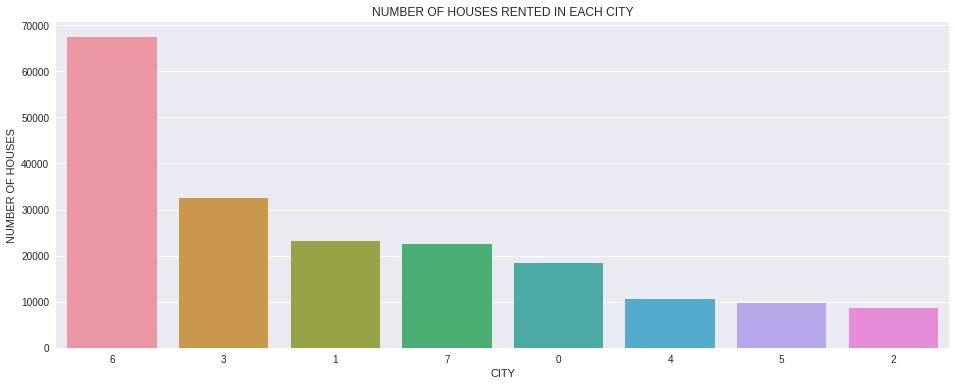

In [ ]:
fig, ax = plt.subplots(figsize=FIGSIZE)
sns.countplot(x=combined['city'],ax=ax,order=combined['city'].value_counts().index)
ax.set_xlabel('CITY')
ax.set_ylabel('NUMBER OF HOUSES')
ax.set_title('NUMBER OF HOUSES RENTED IN EACH CITY')
plt.show()

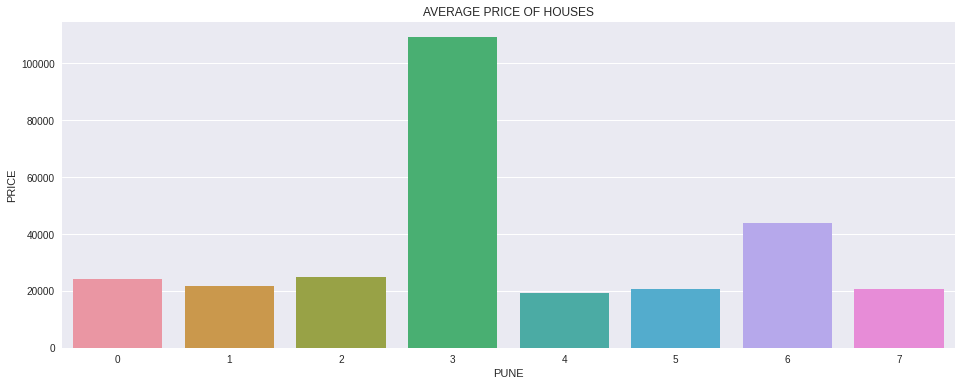

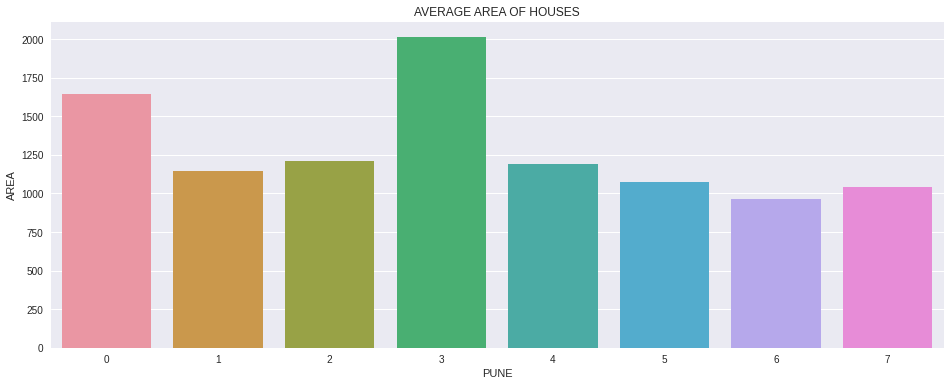

In [ ]:
overall_analysis_cols = ['price','area']
for col in overall_analysis_cols:
    overall_sort_df = combined.groupby(by=['city'])[col].mean().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(16,6))
    sns.barplot(x=overall_sort_df.index, y=overall_sort_df.values,ax=ax)
    ax.set_xlabel(city.upper())
    ax.set_ylabel(col.upper())
    ax.set_title(f'AVERAGE {col.upper()} OF HOUSES')
    plt.show()

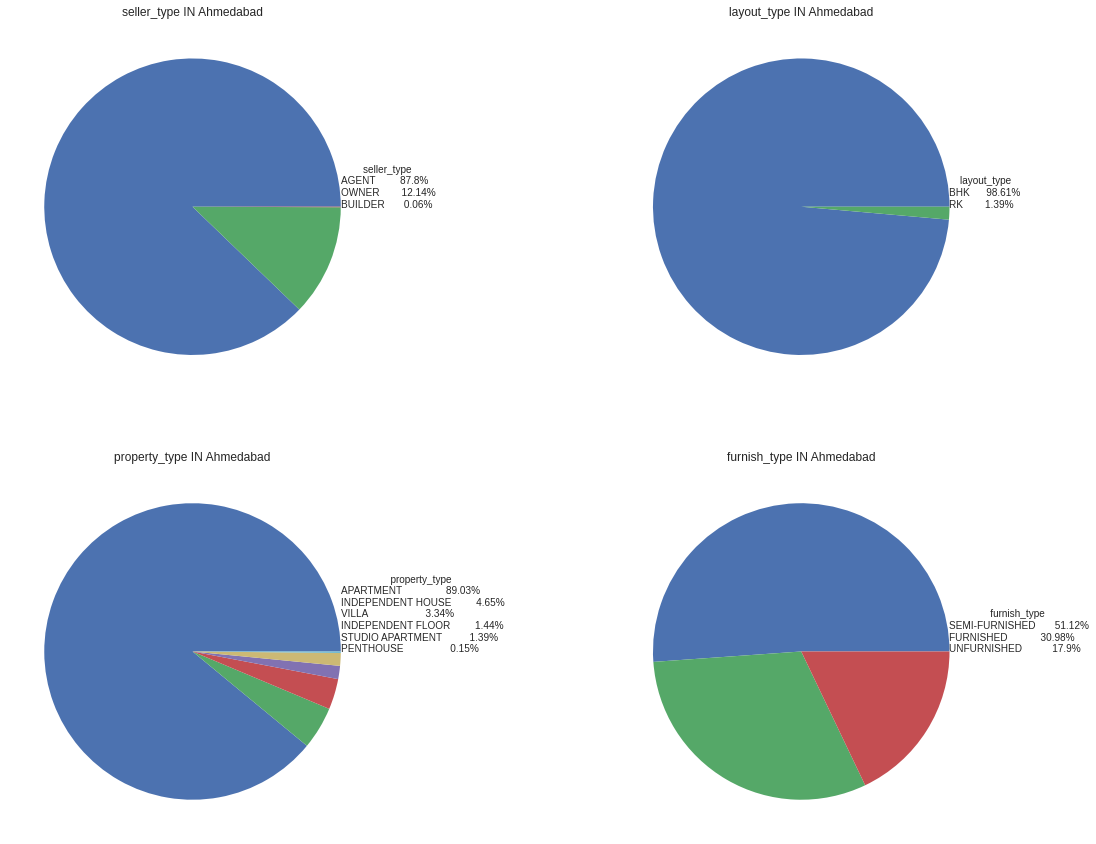

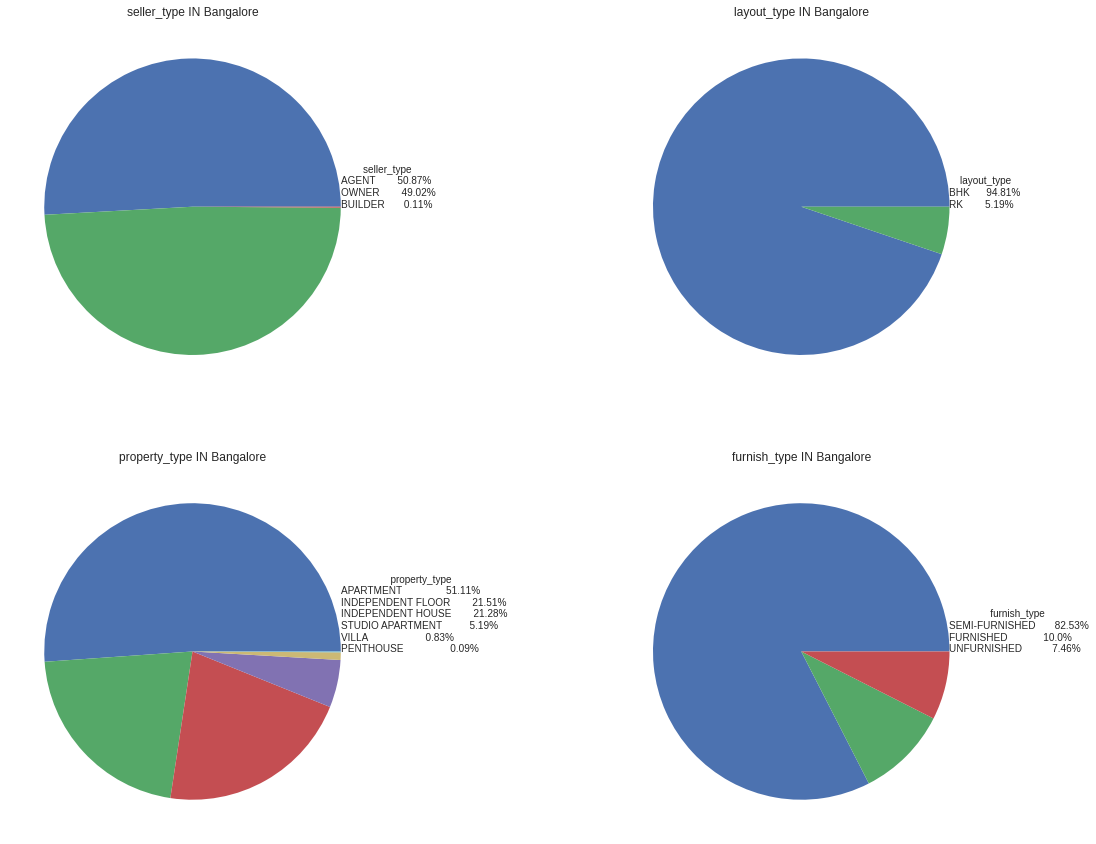

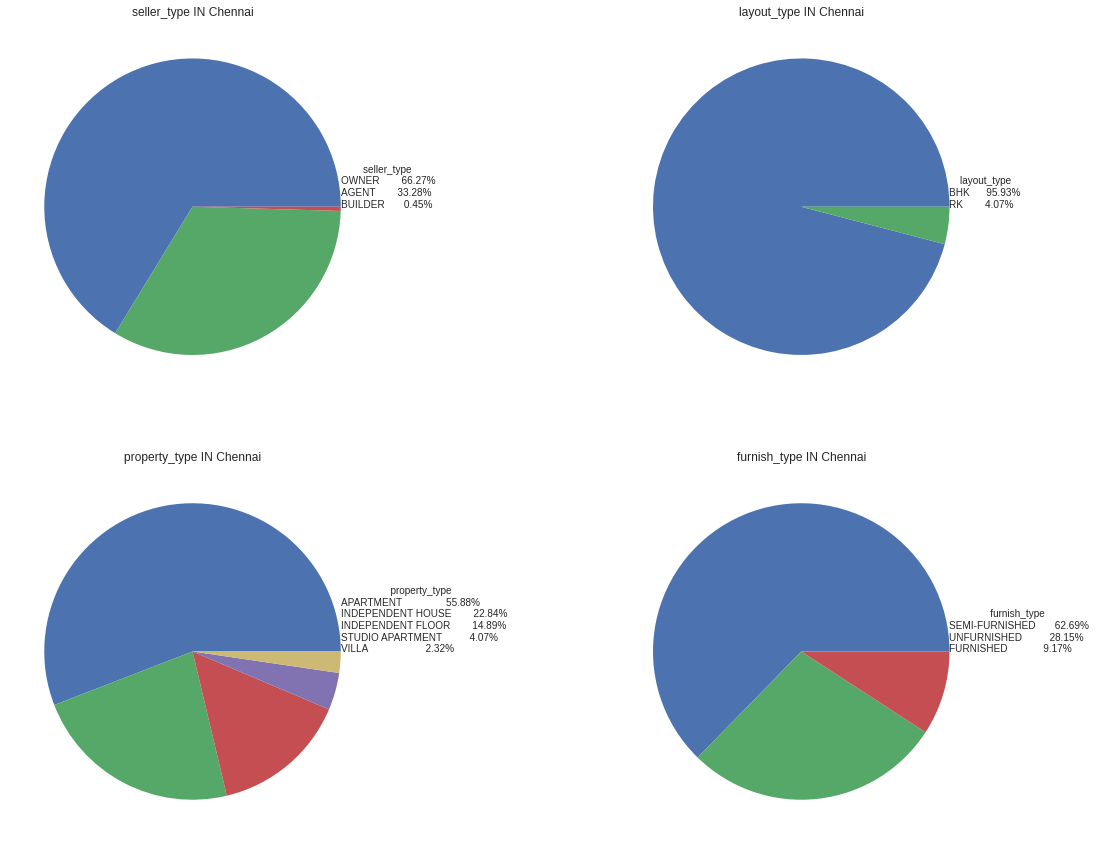

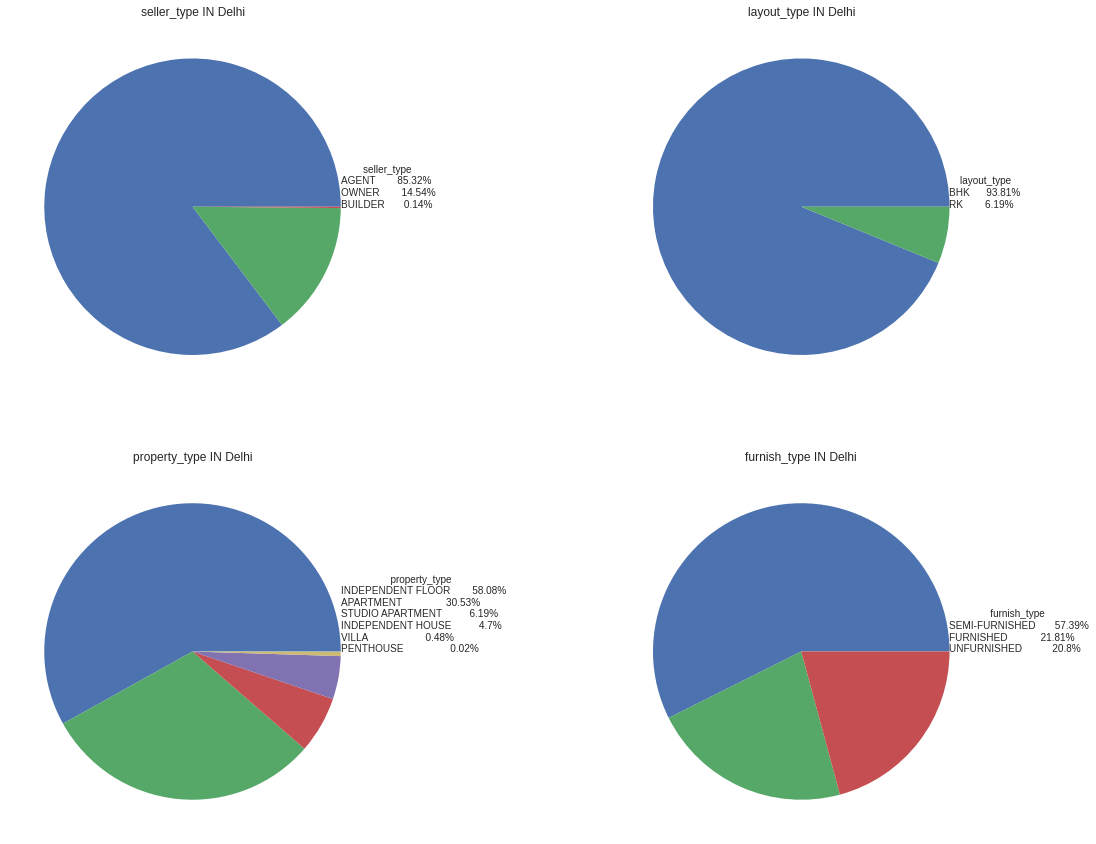

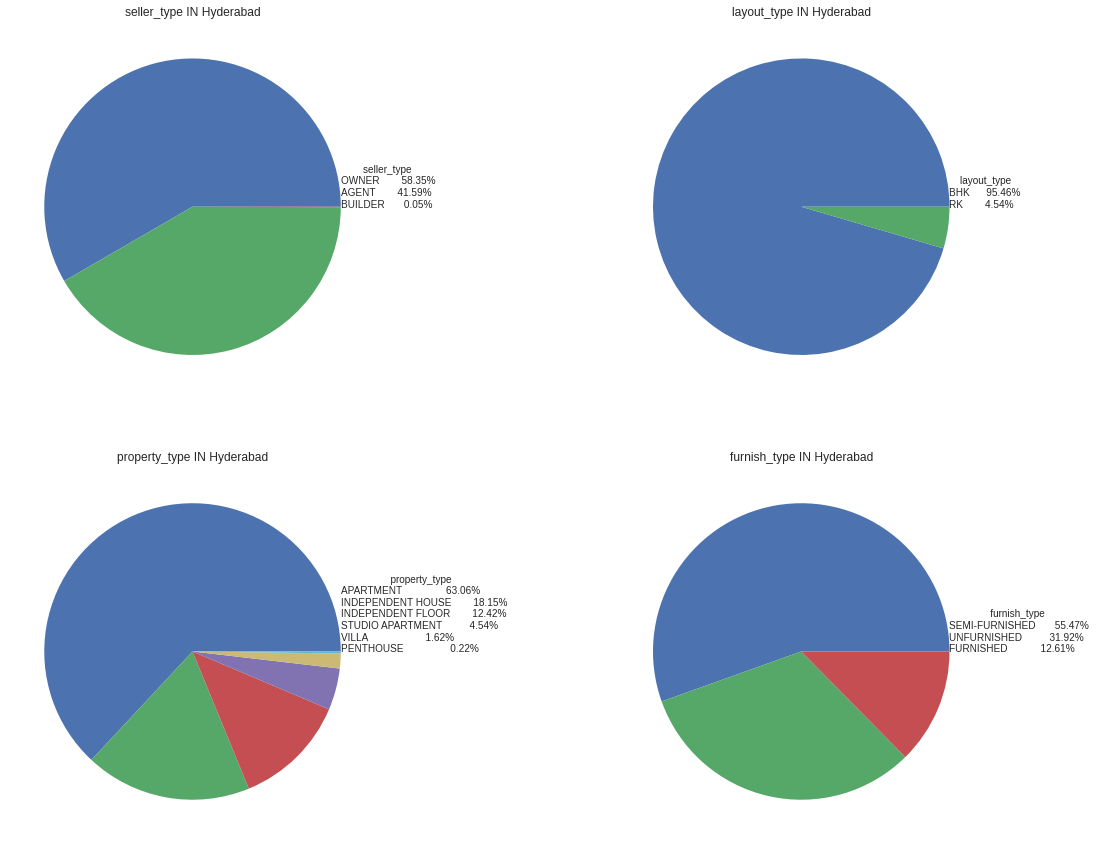

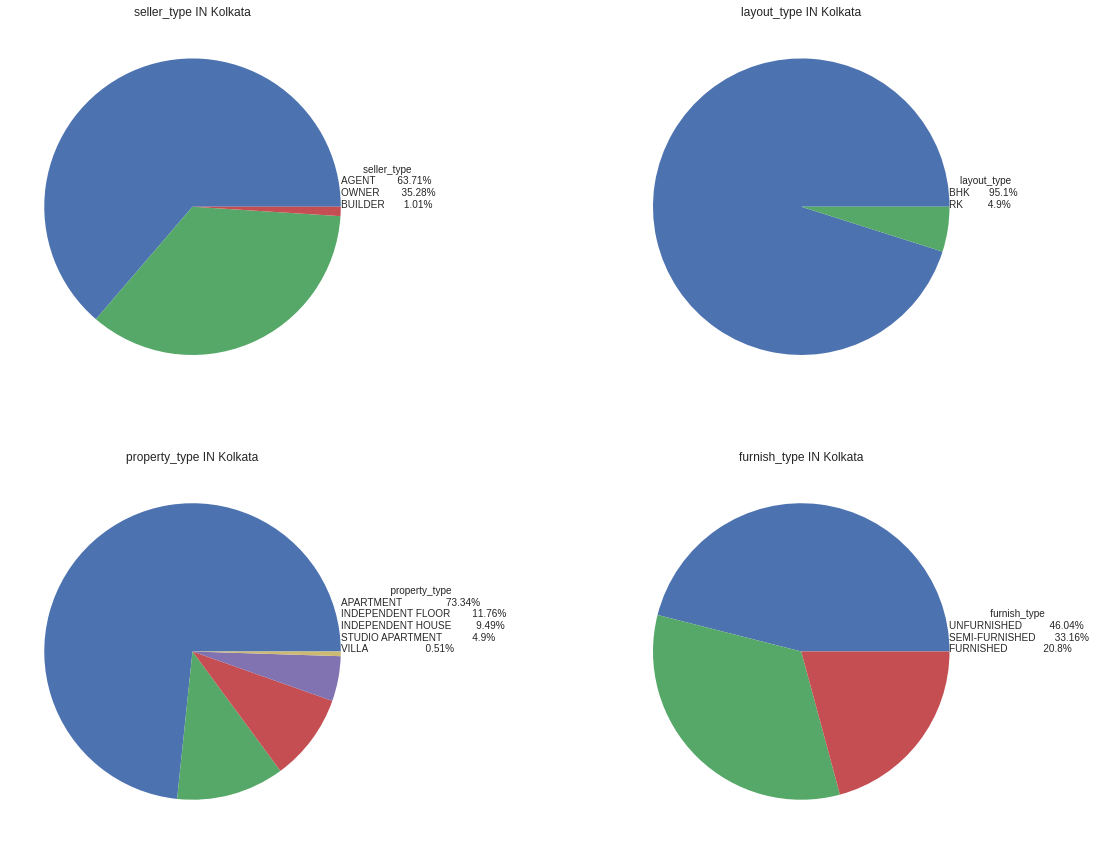

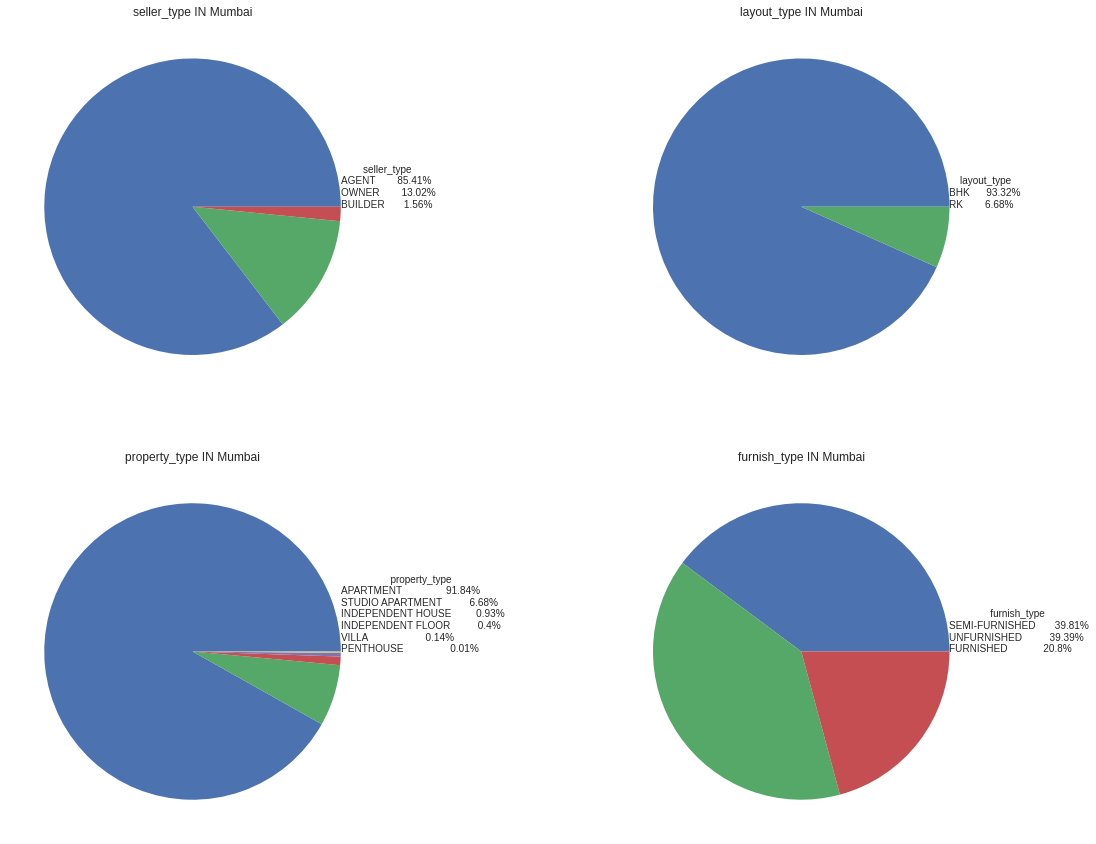

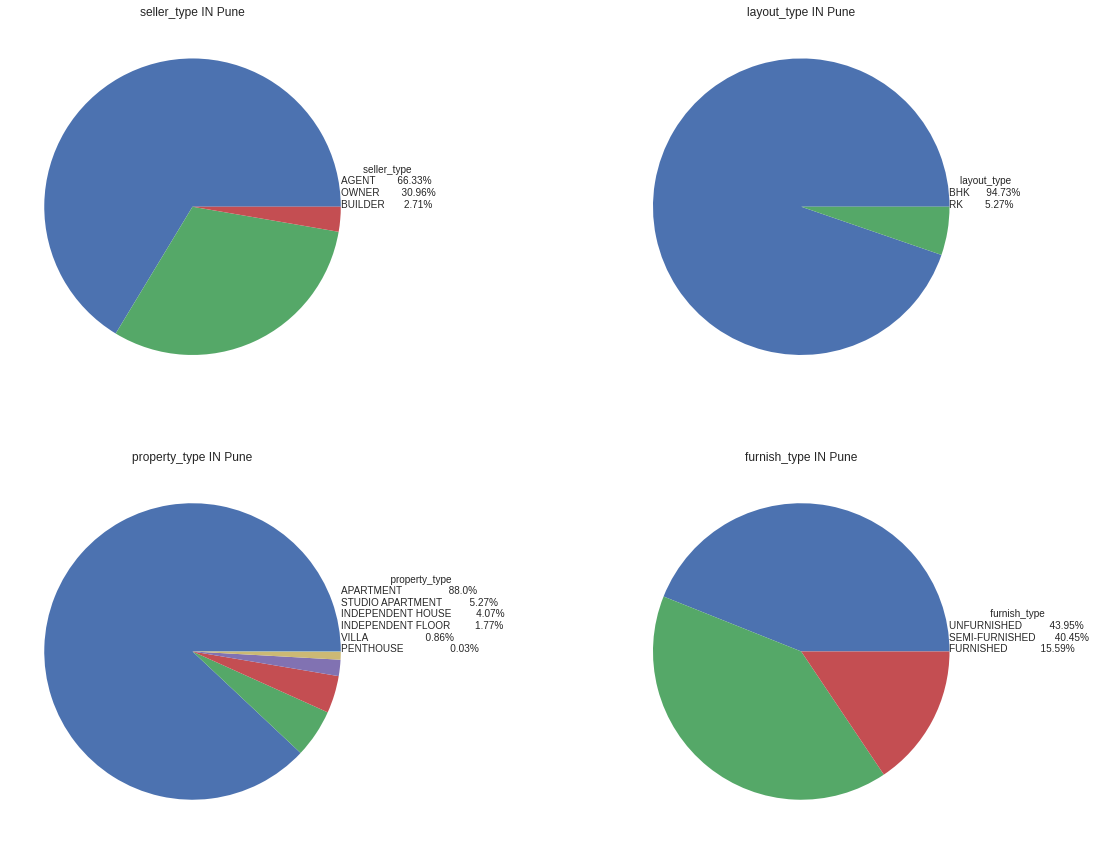

In [ ]:
pie_cols = np.array(['seller_type','layout_type','property_type','furnish_type']).reshape(NUMERICAL_NROWS,NUMERICAL_NCOLS)
for city, df in clean_dict.items():

    fig, ax = plt.subplots(figsize=PIE_FIGSIZE,nrows=NUMERICAL_NROWS, ncols=NUMERICAL_NCOLS)
    for i in range(NUMERICAL_NROWS):
        for j in range(NUMERICAL_NCOLS):
            ax[i,j].pie(x=df[pie_cols[i,j]].value_counts())
            text = pd.DataFrame(df[pie_cols[i,j]].value_counts().apply(lambda x: f'{np.round((x/df.shape[0])*100,2)}%'))
            text.index = text.index.str.upper()
            text = text.to_string()
            ax[i,j].text(1,0,text)
            ax[i,j].set_title(f'{pie_cols[i,j]} IN {city}')
    plt.show()

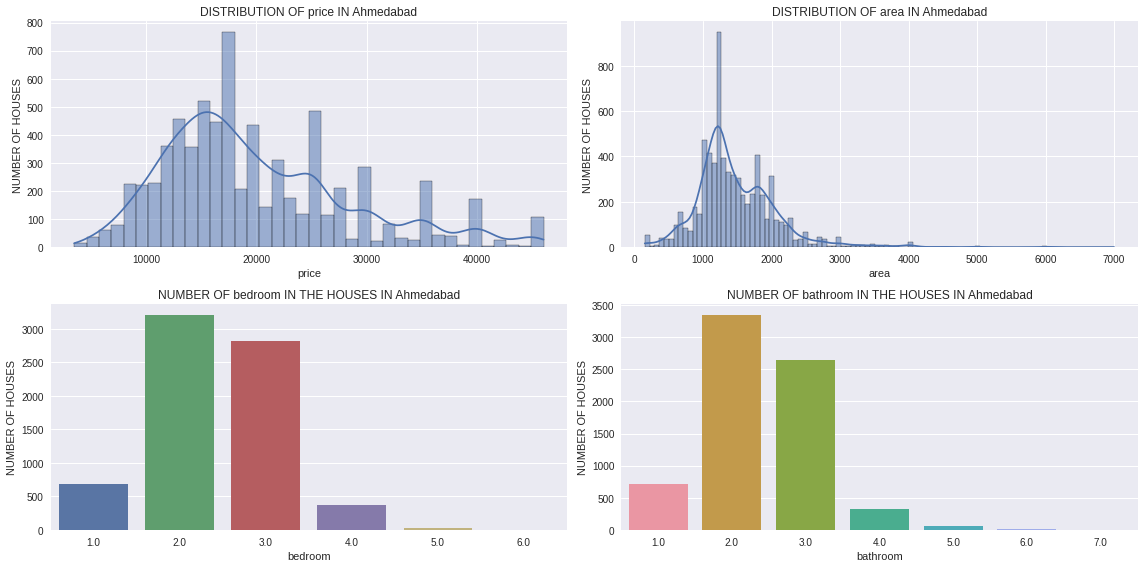

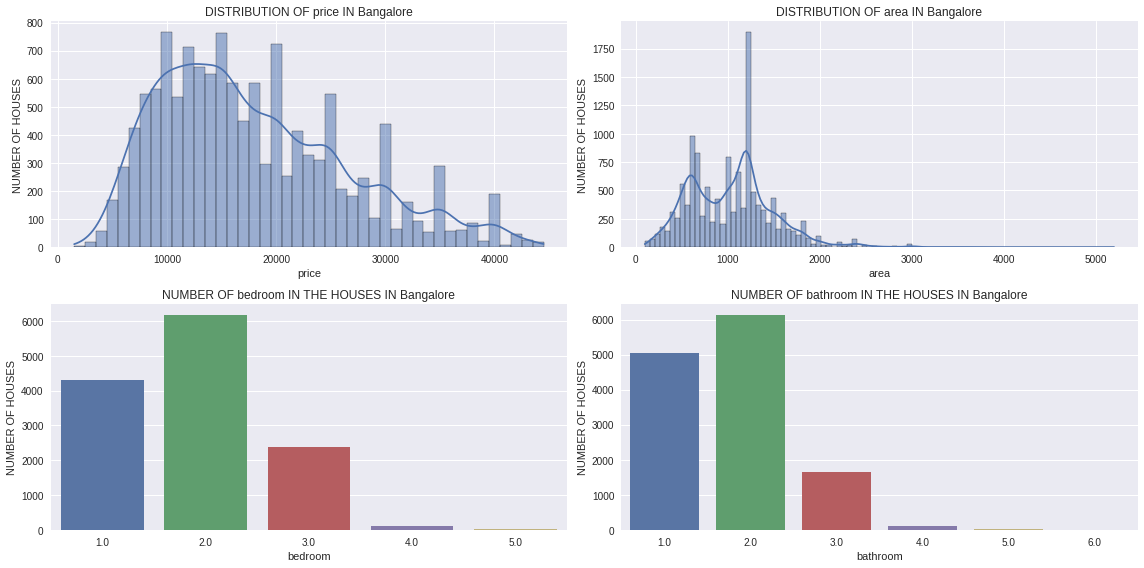

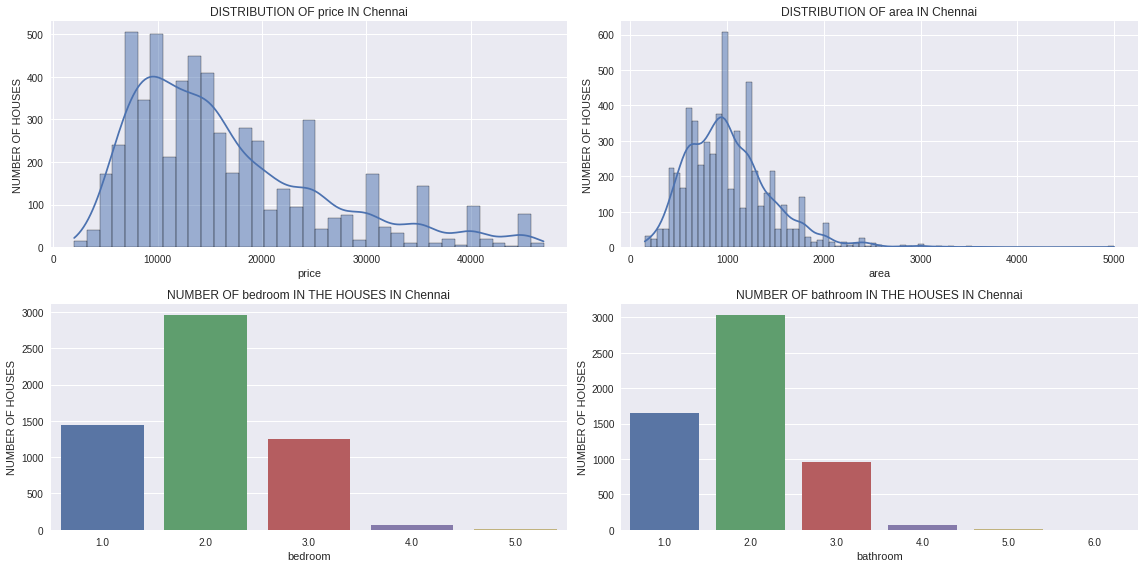

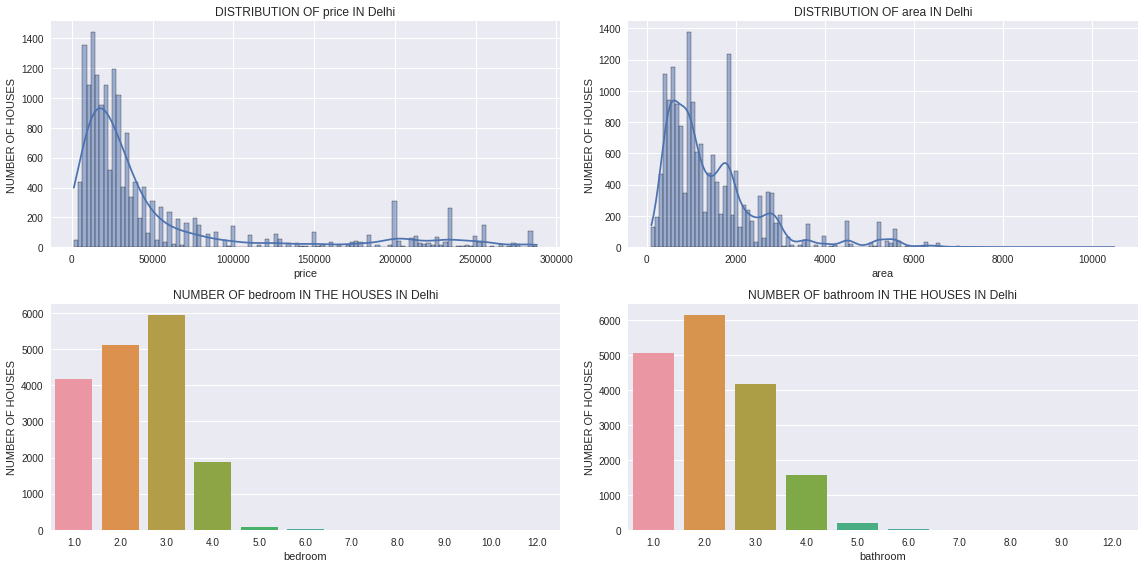

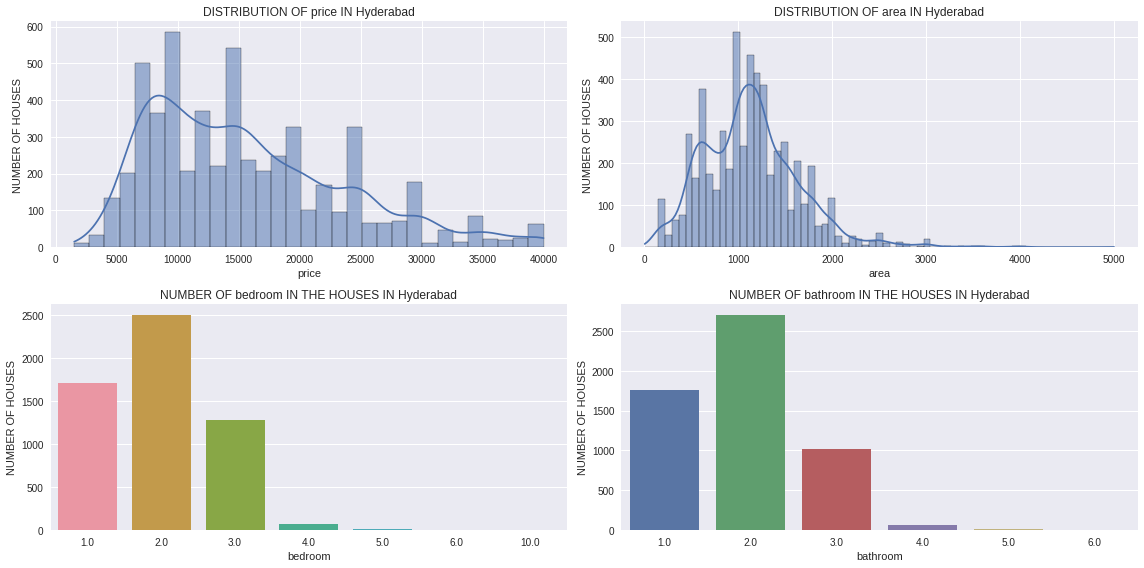

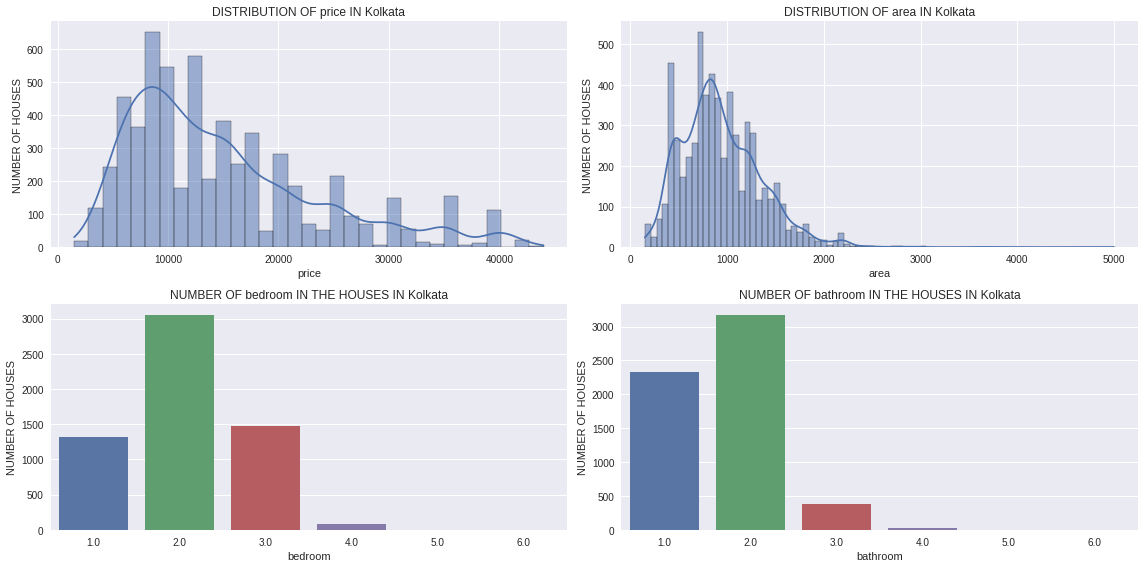

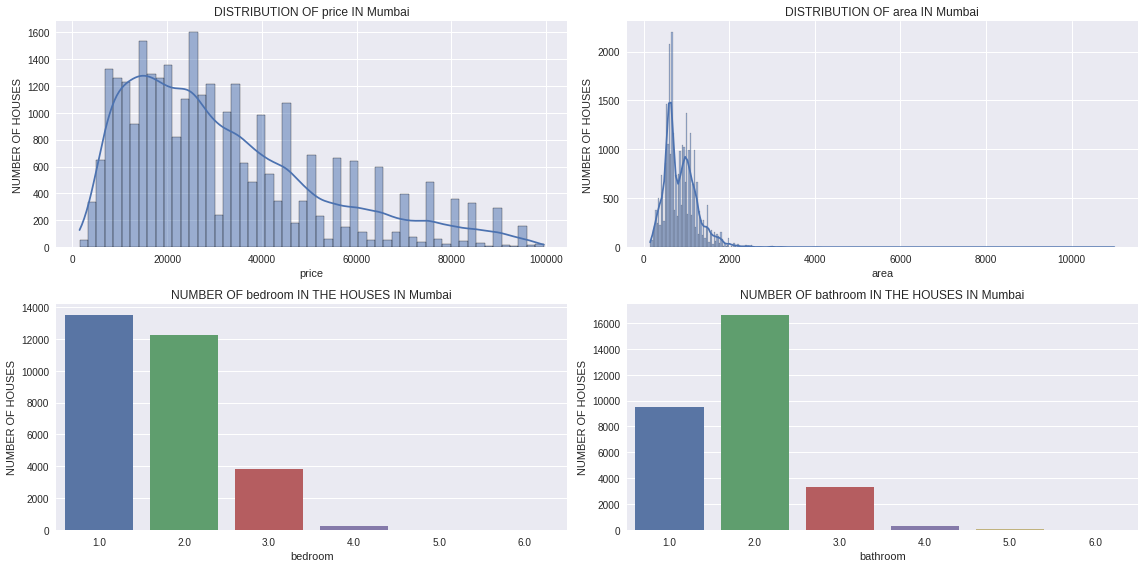

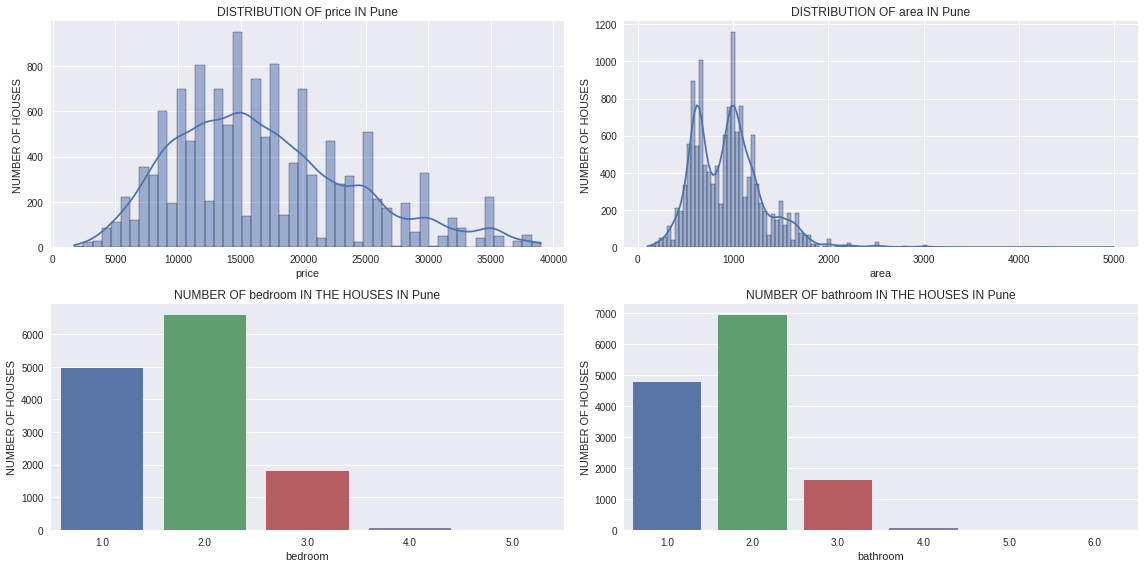

In [ ]:
numerical_cols = np.array([
    ['price','area'],
    ['bedroom','bathroom']
]).reshape(NUMERICAL_NROWS,NUMERICAL_NCOLS)

for city, df in clean_dict.items():
    fig, ax = plt.subplots(figsize=MULTICOL_FIGSIZE,nrows=2,ncols=2)
    for i in range(NUMERICAL_NROWS):
        for j in range(NUMERICAL_NCOLS):
            if i==0:
                sns.histplot(df[numerical_cols[i,j]],ax=ax[i,j],kde=True)
                ax[i,j].set_title(f'DISTRIBUTION OF {numerical_cols[i,j]} IN {city}')
                ax[i,j].set_xlabel(numerical_cols[i,j])
                ax[i,j].set_ylabel('NUMBER OF HOUSES')
            if i==1:
                sns.countplot(x=df[numerical_cols[i,j]],ax=ax[i,j])
                ax[i,j].set_title(f'NUMBER OF {numerical_cols[i,j]} IN THE HOUSES IN {city}')
                ax[i,j].set_xlabel(numerical_cols[i,j])
                ax[i,j].set_ylabel('NUMBER OF HOUSES')
    plt.tight_layout()
    plt.show()

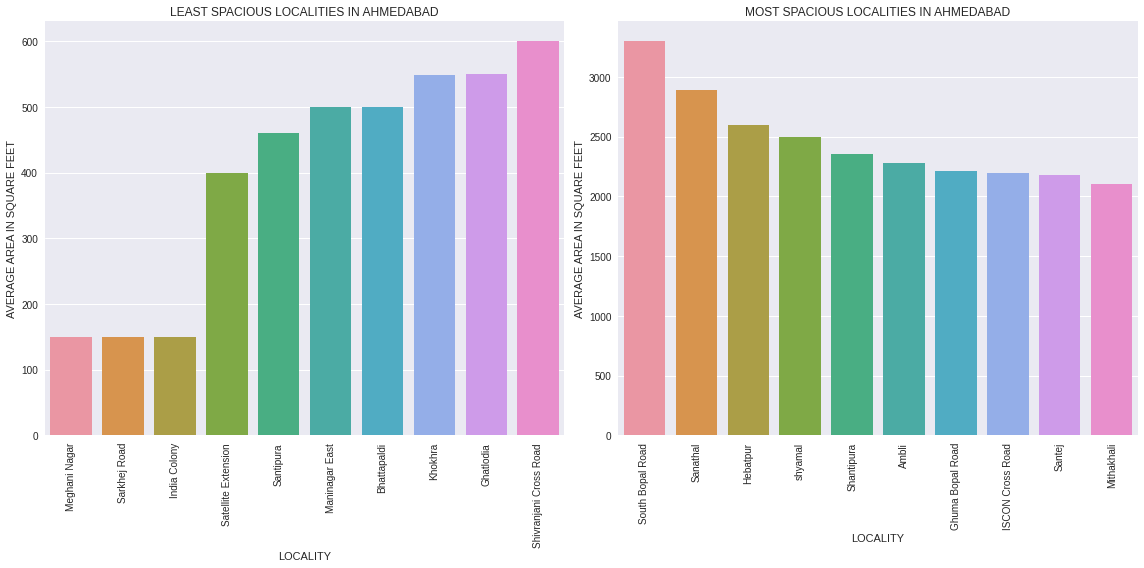

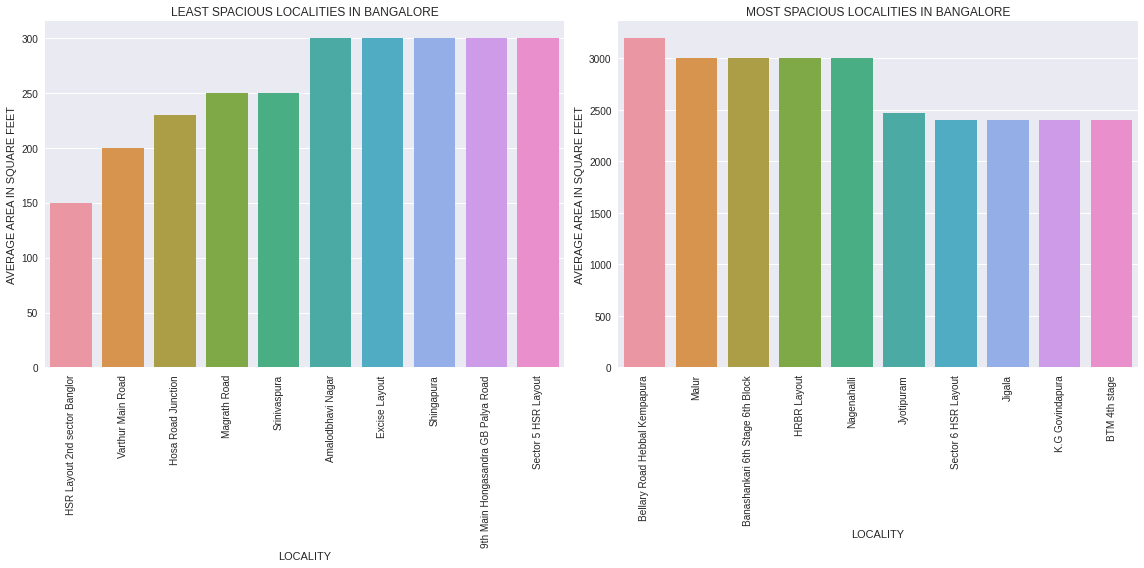

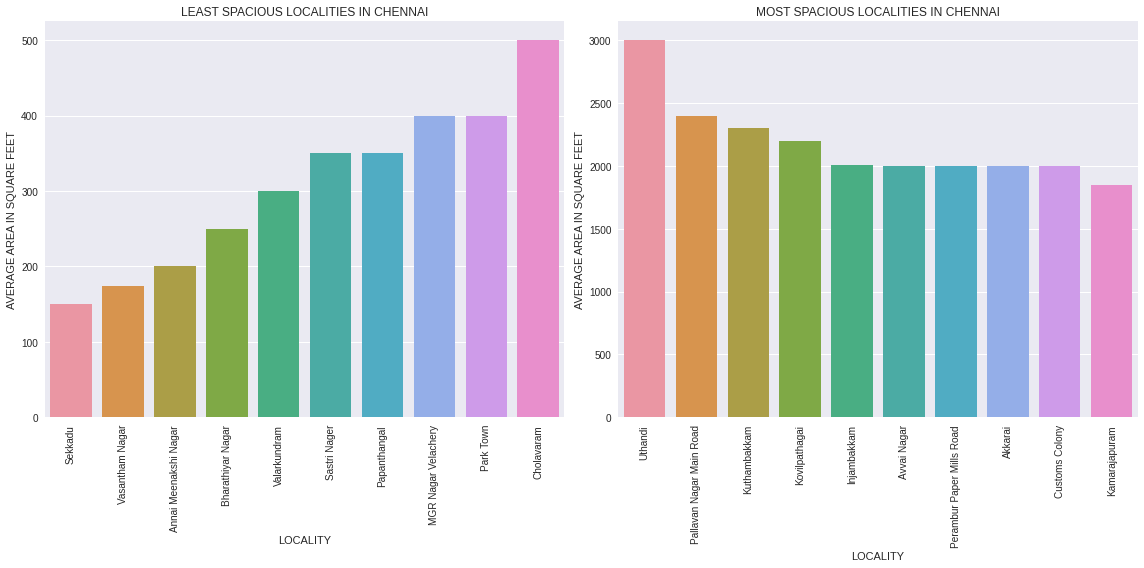

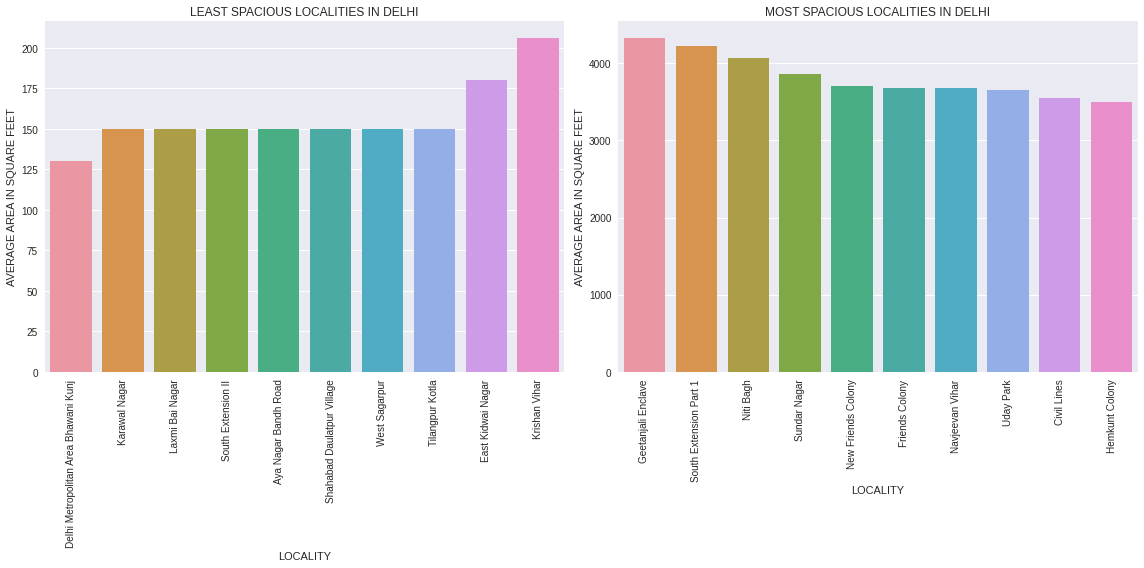

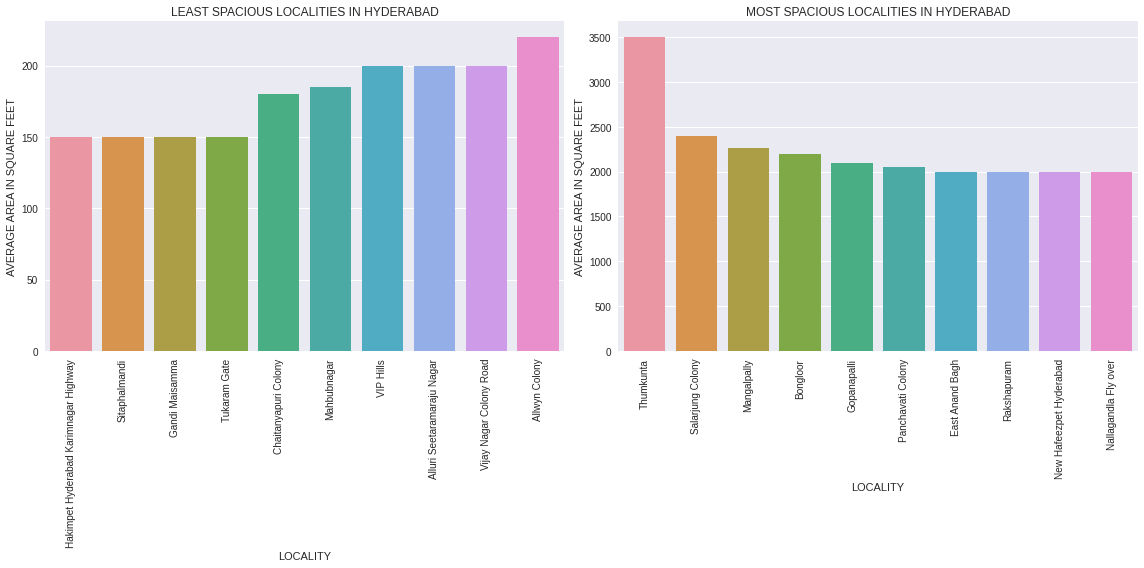

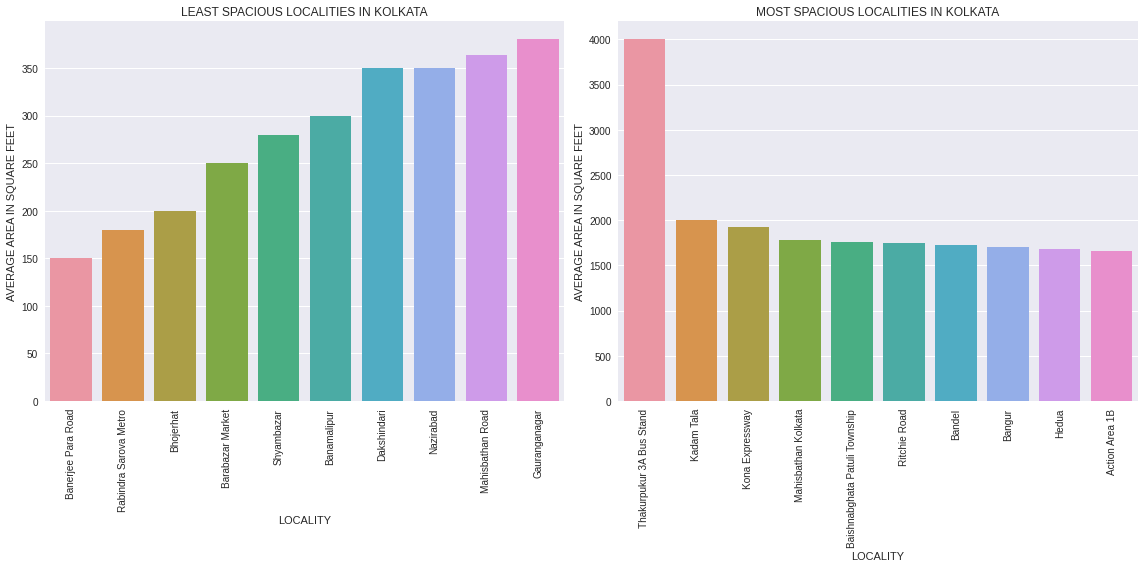

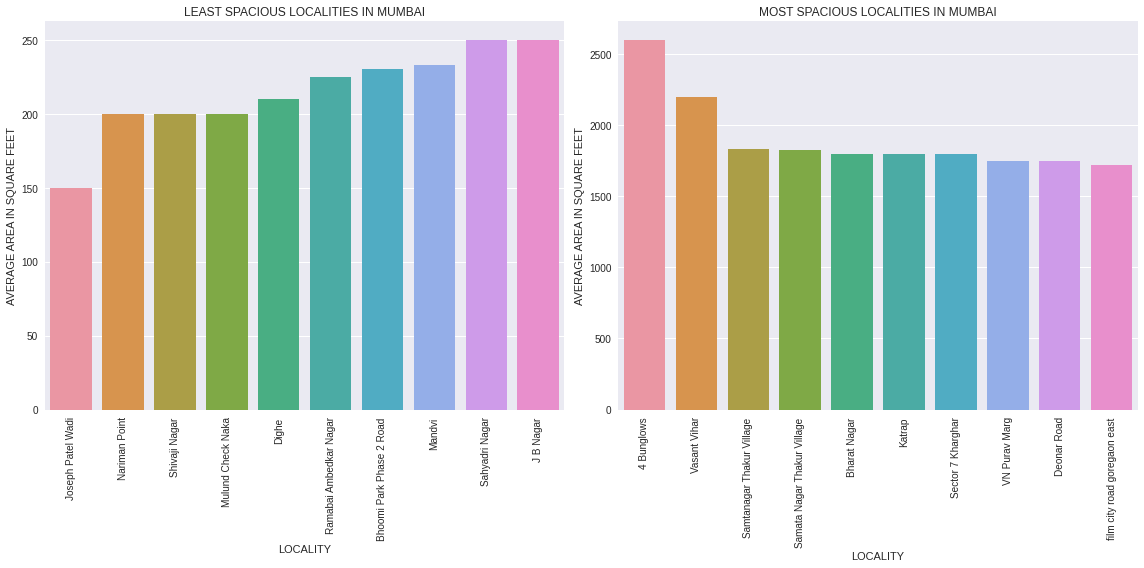

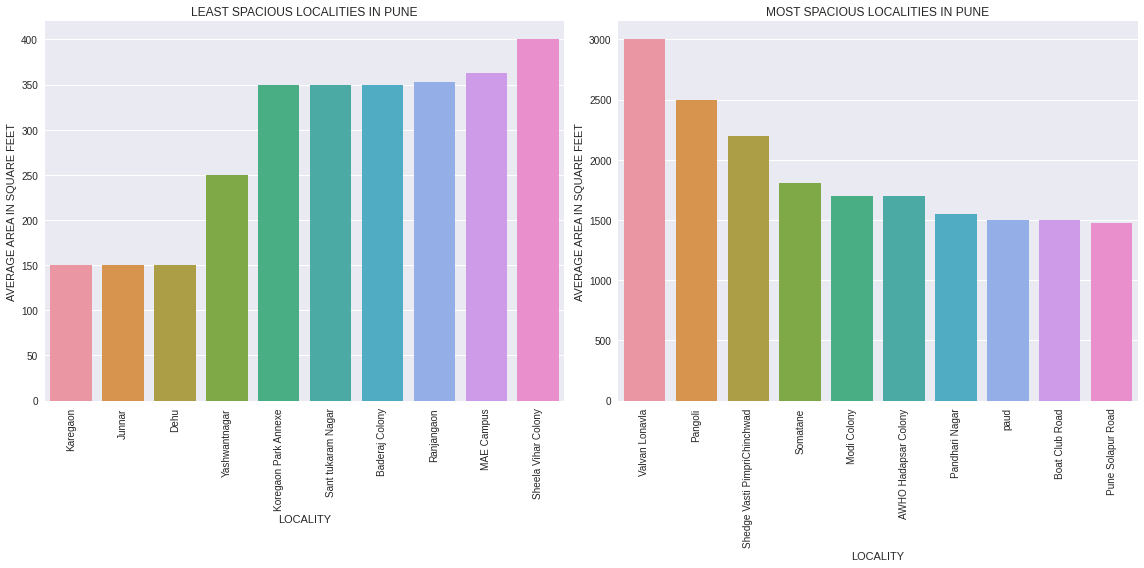

In [ ]:
for city, df in clean_dict.items():
    spacious = df.groupby(by=['locality'])['area'].mean()
    most_spacious = spacious.sort_values(ascending=False)[:10]
    least_spacious = spacious.sort_values(ascending=True)[:10]
    fig, ax = plt.subplots(figsize=MULTICOL_FIGSIZE,nrows=1,ncols=2)
    sns.barplot(x=least_spacious.index, y=least_spacious, ax=ax[0])
    ax[0].set_title(f'LEAST SPACIOUS LOCALITIES IN {city.upper()}')
    ax[0].set_xlabel('LOCALITY')
    ax[0].set_ylabel('AVERAGE AREA IN SQUARE FEET')
    ax[0].tick_params(axis='x',labelrotation=90)
    sns.barplot(x=most_spacious.index, y=most_spacious,ax=ax[1])
    ax[1].set_title(f'MOST SPACIOUS LOCALITIES IN {city.upper()}')
    ax[1].set_xlabel('LOCALITY')
    ax[1].set_ylabel('AVERAGE AREA IN SQUARE FEET')
    ax[1].tick_params(axis='x',labelrotation=90)
    plt.tight_layout()
    plt.show()

# Model Building

In [ ]:
X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}
r2_dict = {}
mae_dict = {}

for city, df in preprocessed_dict.items():
    X = df.drop(['price'],axis=1)
    y = df['price']
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=TEST_SIZE, random_state=RANDOM_STATE)
    X_train_dict[city] = X_train
    y_train_dict[city] = y_train
    X_test_dict[city] = X_test
    y_test_dict[city] = y_test

In [ ]:
def summarize_model(model):

    model_r2_train_dict = {}
    model_r2_test_dict = {}
    model_mae_train_dict = {}
    model_mae_test_dict = {}
    model_dict = {}
    for city in CITIES:
        model.fit(X_train_dict[city],y_train_dict[city])
        model_dict[city] = model
        model_train_preds = model.predict(X_train_dict[city])
        model_test_preds = model.predict(X_test_dict[city])
        model_r2_train_dict[city] = r2_score(y_true=y_train_dict[city], y_pred=model_train_preds)
        model_r2_test_dict[city] = r2_score(y_true=y_test_dict[city], y_pred=model_test_preds)
        model_mae_train_dict[city] = mean_absolute_error(y_true=y_train_dict[city],y_pred=model_train_preds)
        model_mae_test_dict[city] = mean_absolute_error(y_true=y_test_dict[city], y_pred=model_test_preds)
    metrics_dict = {
        'train r2':model_r2_train_dict,
        'test r2':model_r2_test_dict,
        'train mae':model_mae_train_dict,
        'test mae':model_mae_test_dict
    }
    return model_dict, metrics_dict

In [ ]:
price = all_data["price"]
all_data = all_data.drop(["price"],axis=1)

In [ ]:
model = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(all_data, price, test_size = 0.3)
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.623143509428546

In [ ]:
# Linear Regression
lr_dict, lr_metrics = summarize_model(LinearRegression())
display(pd.DataFrame(lr_metrics))

,train r2,test r2,train mae,test mae
Ahmedabad,0.576484,0.572412,4228.388644,4335.716263
Bangalore,0.637631,0.651159,3941.509990,3904.789345
Chennai,0.633526,0.636981,4116.165647,4116.455493
Delhi,0.719554,0.718038,21842.649543,22155.480988
Hyderabad,0.666592,0.657554,3515.501828,3497.878498
Kolkata,0.636213,0.637063,3852.781894,3806.310295
Mumbai,0.437768,0.436943,11819.229907,11952.873775
Pune,0.607654,0.602247,3452.020474,3435.796273


In [ ]:
model = DecisionTreeRegressor()
x_train, x_test, y_train, y_test = train_test_split(all_data, price, test_size = 0.3)
model.fit(x_train,y_train)
model.score(x_test,y_test)


0.851951450487998

In [ ]:
# Decision tree regression
dt_dict, dt_metrics = summarize_model(DecisionTreeRegressor())
display(pd.DataFrame(dt_metrics))


,train r2,test r2,train mae,test mae
Ahmedabad,0.970002,0.527319,592.460513,4024.173246
Bangalore,0.975796,0.532553,486.066014,4252.101765
Chennai,0.991441,0.460838,221.401059,4521.421014
Delhi,0.984221,0.833203,2614.805035,12821.908685
Hyderabad,0.982736,0.502971,339.458933,3920.531300
Kolkata,0.985162,0.562683,328.322697,3896.110060
Mumbai,0.966515,0.727968,1627.022118,6701.284735
Pune,0.963328,0.577419,560.150236,3388.733092


In [ ]:
model = RandomForestRegressor()
x_train, x_test, y_train, y_test = train_test_split(all_data, price, test_size = 0.3)
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.8501566107001979

In [ ]:
# Random forest regression
rf_dict, rf_metrics = summarize_model(RandomForestRegressor())
display(pd.DataFrame(rf_metrics))

,train r2,test r2,train mae,test mae
Ahmedabad,0.937785,0.703912,1473.778430,3321.744107
Bangalore,0.939242,0.708007,1520.954985,3478.630048
Chennai,0.951478,0.673126,1401.162501,3603.911719
Delhi,0.972548,0.894153,5209.945042,10730.179038
Hyderabad,0.947885,0.705842,1303.180197,3051.326056
Kolkata,0.943582,0.704814,1434.229057,3296.799187
Mumbai,0.946891,0.806040,3003.124059,5918.199361
Pune,0.932903,0.696104,1312.805436,2897.193160


In [ ]:
model = AdaBoostRegressor()
x_train, x_test, y_train, y_test = train_test_split(all_data, price, test_size = 0.3)
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.36428588761708514

In [ ]:
# Adaboost Regression
adaboost_dict, adaboost_metrics = summarize_model(AdaBoostRegressor())
display(pd.DataFrame(adaboost_metrics))

,train r2,test r2,train mae,test mae
Ahmedabad,0.541417,0.527390,4690.130639,4819.085471
Bangalore,0.584451,0.591784,4484.245064,4430.503293
Chennai,0.614066,0.600045,4483.168391,4556.102925
Delhi,0.777717,0.775237,18380.132439,19055.173467
Hyderabad,0.635606,0.618400,3882.873034,3876.227410
Kolkata,0.519110,0.496813,5146.344676,5188.285082
Mumbai,0.350215,0.356960,13698.046677,13797.465301
Pune,0.565569,0.546125,3865.613201,3894.021746


In [ ]:
model = GradientBoostingRegressor()
x_train, x_test, y_train, y_test = train_test_split(all_data, price, test_size = 0.3)
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.800686469186187

In [ ]:
# Gradient boosting regression
gb_dict, gb_metrics = summarize_model(GradientBoostingRegressor())
display(pd.DataFrame(gb_metrics))

,train r2,test r2,train mae,test mae
Ahmedabad,0.753599,0.724223,3120.459677,3312.475953
Bangalore,0.728988,0.727768,3390.293014,3424.882231
Chennai,0.754321,0.718986,3259.847268,3477.012958
Delhi,0.888856,0.885624,11411.916630,11806.304187
Hyderabad,0.765201,0.717992,2903.159116,3057.142798
Kolkata,0.750896,0.722470,3098.940022,3243.350973
Mumbai,0.719642,0.712311,7900.784804,8006.668770
Pune,0.743454,0.707644,2745.689778,2874.677614


In [ ]:
model = XGBRegressor(objective='reg:squarederror')
x_train, x_test, y_train, y_test = train_test_split(all_data, price, test_size = 0.3)
model.fit(x_train,y_train)
model.score(x_test,y_test)

0.788723846712633

In [ ]:
# XGBoost Regression
xgb_dict, xgb_metrics = summarize_model(XGBRegressor(objective='reg:squarederror'))
display(pd.DataFrame(xgb_metrics))

,train r2,test r2,train mae,test mae
Ahmedabad,0.750423,0.723772,3130.131151,3315.268138
Bangalore,0.728929,0.729037,3388.812898,3416.616904
Chennai,0.752854,0.718837,3266.821601,3483.508672
Delhi,0.888972,0.887304,11329.974863,11712.148117
Hyderabad,0.765579,0.716518,2904.358894,3071.873996
Kolkata,0.750956,0.728194,3099.652748,3226.168407
Mumbai,0.724767,0.718531,7836.659911,7938.092655
Pune,0.739080,0.702834,2766.008678,2898.012869


In [ ]:
model_dict = {
    'LR':lr_dict,
    'DT':dt_dict,
    'RF':rf_dict,
    'ADA':adaboost_dict,
    'GB':gb_dict,
    'XGB':xgb_dict
}
model_metrics = {
    'LR':lr_metrics,
    'DT':dt_metrics,
    'RF':rf_metrics,
    'ADA':adaboost_metrics,
    'GB':gb_metrics,
    'XGB':xgb_metrics
}

In [ ]:
train_r2 = {}
test_r2 = {}
train_mae = {}
test_mae = {}

for model, metrics_dict in model_metrics.items():
    train_r2[model] = metrics_dict['train r2']
    test_r2[model] = metrics_dict['test r2']
    train_mae[model] = metrics_dict['train mae']
    test_mae[model] = metrics_dict['test mae']

In [ ]:
train_r2 = pd.DataFrame(train_r2)
test_r2 = pd.DataFrame(test_r2)
train_mae = pd.DataFrame(train_mae)
test_mae = pd.DataFrame(test_mae)

In [ ]:
train_r2.columns = [col+'_train_r2' for col in train_r2.columns]
test_r2.columns = [col+'_test_r2' for col in test_r2.columns]
train_mae.columns = [col+'_train_mae' for col in train_mae.columns]
test_mae.columns = [col+'_test_mae' for col in test_mae.columns]

In [ ]:
plot_r2 = pd.DataFrame()
for c1, c2 in zip(train_r2.columns, test_r2.columns):
    plot_r2[c1] = train_r2[c1]
    plot_r2[c2] = test_r2[c2]

In [ ]:
plot_mae = pd.DataFrame()
for c1,c2 in zip(train_mae.columns, test_mae.columns):
    plot_mae[c1] = train_mae[c1]
    plot_mae[c2] = test_mae[c2]

In [ ]:
plot_r2 = plot_r2.T
plot_mae = plot_mae.T

In [ ]:
cities_plot = np.array(CITIES).reshape(CITY_NROWS,CITY_NCOLS)

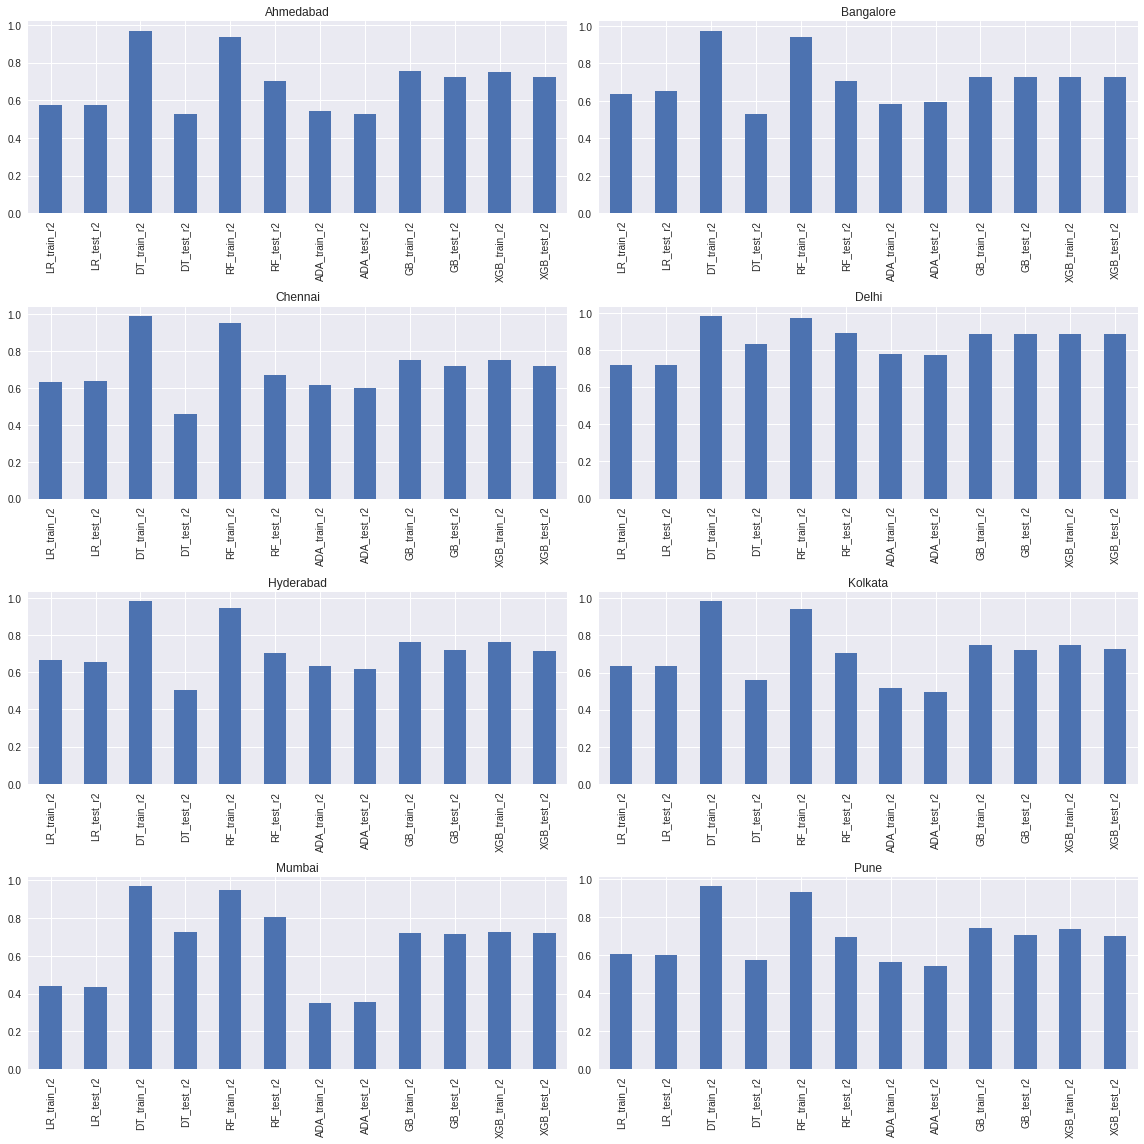

In [ ]:
fig, ax = plt.subplots(figsize=(16,16),nrows=4,ncols=2)
for i in range(4):
    for j in range(2):
        plot_r2[cities_plot[i,j]].plot(kind='bar',ax=ax[i,j])
        ax[i,j].set_title(cities_plot[i,j])
plt.tight_layout()
plt.show()

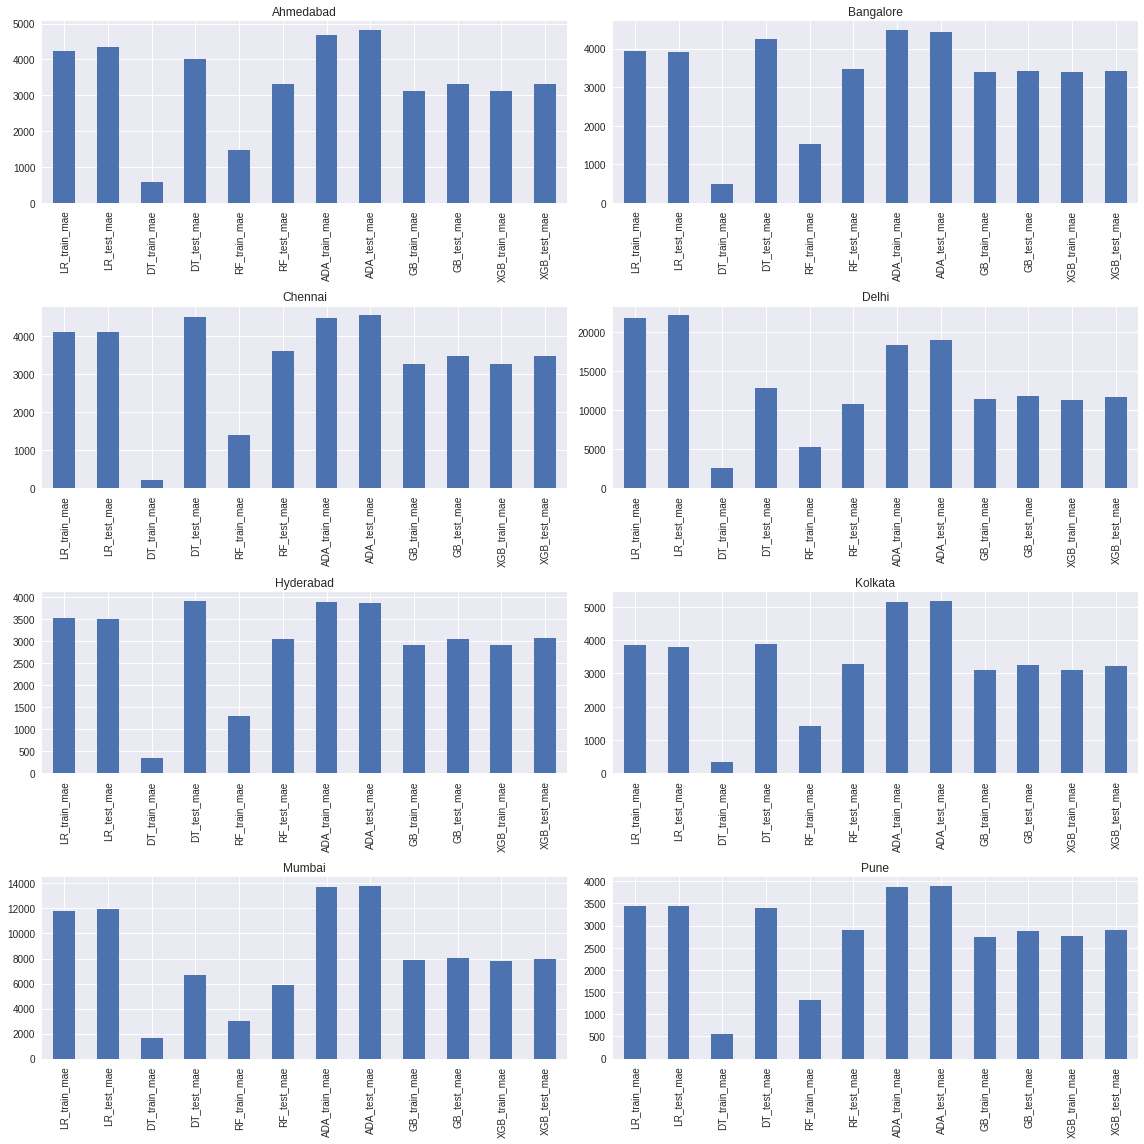

In [ ]:
fig, ax = plt.subplots(figsize=(16,16),nrows=4,ncols=2)
for i in range(4):
    for j in range(2):
        plot_mae[cities_plot[i,j]].plot(kind='bar',ax=ax[i,j])
        ax[i,j].set_title(cities_plot[i,j])
plt.tight_layout()
plt.show()

From the above graphs, we can say that Randomforest() has the highest r2 score for all the cities and the lowest MAE, hence we will validate the Randomforest() model for GridSearchCV()